In [1]:
import os
import pandas as pd
import numpy as np
import qcodes as qc
import plotly.io as pio
import plotly.graph_objects as go
from qcodes.dataset import (
    Measurement, initialise_or_create_database_at,
    load_or_create_experiment, plot_dataset
)
from qcodes.parameters import Parameter

In [3]:
initialise_or_create_database_at(r"PtTe2_NbTi_B7_2024-07-02_01.db")
qc.experiments()


[I vs V#100KOhm_100mKIV_standard1K#1@/Users/albert-mac/Code/GitHub/QCoDeS_local/personal_scripts/Thomas/PtTe2/PtTe2_NbTi_B7_2024-07-02_01.db
 -------------------------------------------------------------------------------------------------------------------------------------------
 1-results-1-appl_current,meas_voltage_K2-101,
 I vs V#100KOhm_100mKIV_standard1K#2@/Users/albert-mac/Code/GitHub/QCoDeS_local/personal_scripts/Thomas/PtTe2/PtTe2_NbTi_B7_2024-07-02_01.db
 -------------------------------------------------------------------------------------------------------------------------------------------
 2-results-1-appl_current,meas_voltage_K2-101,
 I vs V#100KOhm_100mKIV_standard1K#3@/Users/albert-mac/Code/GitHub/QCoDeS_local/personal_scripts/Thomas/PtTe2/PtTe2_NbTi_B7_2024-07-02_01.db
 -------------------------------------------------------------------------------------------------------------------------------------------
 3-results-1-appl_current,meas_voltage_K2-101,
 I vs V#100KO

# Import

In [53]:
dataset = qc.load_by_id(1)
def extract_sample_and_number(sample_name):
    # Define the pattern for extracting the sample and number
    pattern = r'(?P<sample>.*?)(?P<number>\d+)$'

    # Use regular expression to extract the sample and number
    match = re.match(pattern, sample_name)

    if match:
        sample = match.group('sample')
        number = int(match.group('number'))
        return sample, number
    else:
        return None, None


def extract_sample_junction(sample_name):
    """Extracts the complete sample junction from the provided sample name.

    Args:
      sample_name: The name of the sample containing the junction information.

    Returns:
      The extracted sample junction, or None if not found.
    """

    delimiter = "_J"
    if delimiter in sample_name:
        # +3 to include "_J"
        return sample_name[:sample_name.find(delimiter) + 3]
    else:
        return None
    
def get_detaset_info(dataset=dataset):
    run_id = dataset.captured_run_id
    exp_name = dataset.exp_name
    sample_name = dataset.sample_name
    name = dataset.name
    description = dataset.description
    sample_junction = extract_sample_junction(sample_name)
    return run_id, exp_name, sample_name, sample_junction, name, description

def IV_Mag_plot(run_id, save=False, log_lower_limit= 0):
    # Load the dataset
    dataset = qc.load_by_id(run_id)
    # Get the dataset info
    run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(
        dataset)
    df = dataset.to_pandas_dataframe().reset_index()
    # Plot the dataset
    plot_dataset(dataset)
    para_list = dataset.parameters.split(",")

    fig1 = go.Figure(data=go.Heatmap(
        x=df[para_list[0]],
        y=df[para_list[1]],
        z=df[para_list[2]],
        colorscale='RdBu',
        colorbar=dict(
            title=para_list[2], titleside='top')),
        layout=dict(
            title=f"#{run_id} {exp_name} {sample_name}",
            xaxis_title=para_list[0],
            yaxis_title=para_list[1],
            height=800, width=800

    ))
    # fig1.show()

    df['differential_voltage'] = (
        df[para_list[2]].shift(-1) -
        df[para_list[2]].shift(1)) / (2 * (df[para_list[1]].shift(-1) - df[para_list[1]]))
    fig2 = go.Figure(data=go.Heatmap(
        x=df[para_list[0]],
        y=df[para_list[1]],
        z=df['differential_voltage'],
        colorscale='RdBu',
        colorbar=dict(
            title='dV/dI', titleside='top')),
        layout=dict(
            title=f"#{run_id} dV/dI {sample_name}",
            xaxis_title=para_list[0],
            yaxis_title=para_list[1],
            height=800, width=800
    ))
    # fig2.show()
    fig3 = go.Figure(data=go.Heatmap(
        x=df[para_list[0]],
        y=df[para_list[1]],
        z=np.log10(df['differential_voltage'].replace(0, 1e-20).clip(lower=log_lower_limit)),
        colorscale='RdBu',
        colorbar=dict(
            title='dV/dI(Log)', titleside='top')),
        layout=dict(
            title=f"#{run_id} dV/dI {sample_name}",
            xaxis_title=para_list[0],
            yaxis_title=para_list[1],
            height=800, width=800
    ))
    # fig3.show()
    import plotly.subplots as subplots

    # ...

    # Create figure layouts
    fig1_layout = fig1.layout
    fig2_layout = fig2.layout
    fig3_layout = fig3.layout

    # Create a grid of subplots
    fig = subplots.make_subplots(rows=1, cols=3, subplot_titles=('IV Magnitude', 'dV/dI','dV/dI(Log)' ))

    # Add traces to the subplots
    fig.add_trace(fig1.data[0], row=1, col=1)
    fig.add_trace(fig2.data[0], row=1, col=2)
    fig.add_trace(fig3.data[0], row=1, col=3)

    # Update the layout with titles and dimensions
    fig.layout.update(title_text=f"#{run_id} {exp_name} {sample_name}", height=800, width=2400)

    # Update xaxis and yaxis properties individually
    fig.update_xaxes(fig1_layout.xaxis, row=1, col=1)
    fig.update_yaxes(fig1_layout.yaxis, row=1, col=1)
    fig.update_xaxes(fig2_layout.xaxis, row=1, col=2)
    fig.update_yaxes(fig2_layout.yaxis, row=1, col=2)
    fig.update_xaxes(fig3_layout.xaxis, row=1, col=3)
    fig.update_yaxes(fig3_layout.yaxis, row=1, col=3)
    fig.data[0].colorbar.x = 0.288  # Adjust x position of the first colorbar
    fig.data[1].colorbar.x = 0.642 
    fig.data[2].colorbar.x = 1 

    # Show the combined figure
    # fig.show()
    fig1.show()
    fig2.show()   
    fig3.show()

    if save == True:
        pio.write_image(fig1, rf"D:\data\Albert\103\Plot\103_{run_id}_IV_Mag.png")
        pio.write_image(fig2, rf"D:\data\Albert\103\Plot\103_{run_id}_dVdI.png")
        pio.write_image(fig3, rf"D:\data\Albert\103\Plot\103_{run_id}_dVdI(Log).png")


def IV_RF_f_linecut(run_id, target_frequencies=[5.0, 6.0]):
    dataset = qc.load_by_id(run_id)
    run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(
        dataset)
    df = dataset.to_pandas_dataframe().reset_index()
    para_list = dataset.parameters.split(",")
    
    fig = go.Figure()
    
    for target_frequency in target_frequencies:
        # Find the closest value to the target frequency
        closest_frequency = df[para_list[0]].iloc[(df[para_list[0]]-target_frequency*1e9).abs().argsort()[:1]].values[0]

        # Filter the data for the closest frequency
        SGS_cut = df[df[para_list[0]] == closest_frequency]

        # Linecut plot
        fig.add_trace(go.Scatter(x=SGS_cut[para_list[1]], y=SGS_cut[para_list[2]], mode='lines', name=f'{closest_frequency*1e-9:.4f} GHz'))

    fig.update_layout(
        title=f"#{run_id} {exp_name} {sample_name} <br> Linecut",
        xaxis_title=para_list[1],
        yaxis_title=para_list[2],
        height=800, width=800,
        legend=dict(
            orientation="h",
            yanchor="top",
            y=1.05,
            xanchor="center",
            x=0.5
    ))

    fig.show()

def IV_RF_PD_linecut(run_id, target_powers=[-10.0, 0.0]):
    dataset = qc.load_by_id(run_id)
    run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(
        dataset)
    df = dataset.to_pandas_dataframe().reset_index()
    para_list = dataset.parameters.split(",")
    
    fig = go.Figure()
    
    for target_power in target_powers:
        # Find the closest value to the target power
        closest_power = df[para_list[0]].iloc[(df[para_list[0]]-target_power).abs().argsort()[:1]].values[0]

        # Filter the data for the closest frequency
        SGS_cut = df[df[para_list[0]] == closest_power]

        # Linecut plot
        fig.add_trace(go.Scatter(x=SGS_cut[para_list[1]], y=SGS_cut[para_list[2]], mode='lines', name=f'{closest_power:.1f} dBm'))

    fig.update_layout(
        title=f"#{run_id} {exp_name} {sample_name} <br> Linecut",
        xaxis_title=para_list[1],
        yaxis_title=para_list[2],
        height=800, width=800,
        legend=dict(
            orientation="h",
            yanchor="top",
            y=1.05,
            xanchor="center",
            x=0.5
    ))

    fig.show()

def IV(run_id=1):
    dataset = qc.load_by_id(run_id)
    R = get_R_from_IV(run_id)
    run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(
        dataset)
    df = dataset.to_pandas_dataframe().reset_index()
    para_list = dataset.parameters.split(",")

    # Create a Plotly trace
    trace = go.Scatter(x=df[para_list[0]], y=df[para_list[1]]*1e3, mode='lines', name='Voltage vs. Current')

    # Create layout with micro-scale y-axis
    layout = go.Layout(title=f'<b>#{run_id} {exp_name}</b> {sample_name}, R_fit={R:.4f} Ω', title_font=dict(size=28),
                       xaxis=dict(title=para_list[0], tickfont=dict(size=16),title_font=dict(size=20)),
                       yaxis=dict(title=f"{para_list[1]} mV", tickfont=dict(size=16),title_font=dict(size=20)), 
                       width=1080, height=960,
                       margin=dict(l=10, r=10, t=50, b=10))

    # Create the figure
    fig = go.Figure(data=[trace], layout=layout)
    
    fig.show()

def IV_diff(run_id=1):
    import numpy as np
    import plotly.graph_objs as go
    from scipy.signal import find_peaks
    dataset = qc.load_by_id(run_id)
    run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(
        dataset)
    df = dataset.to_pandas_dataframe().reset_index()
    para_list = dataset.parameters.split(",")

    current = df[para_list[0]].tolist()
    voltage = df[para_list[1]].tolist()

    # Compute differential of voltage with respect to current
    differential_voltage = np.diff(voltage) / np.diff(current)

    # Since the differential will have one less data point, adjust the current data
    # to have the same length as the differential data
    current = current[:-1]

    # Find peaks in the differential signal
    peaks, _ = find_peaks(differential_voltage)

    # Extract peak current and peak differential voltage values
    peak_current = [current[i] for i in peaks]
    peak_voltage_diff = [differential_voltage[i] for i in peaks]

    # Sort the peaks based on their values
    sorted_peak_indices = np.argsort(peak_voltage_diff)[::-1]  # Sort in descending order
    top_two_peak_indices = sorted_peak_indices[:2]  # Select the top two indices

    # Extract the top two peaks
    top_two_peak_current = [peak_current[i] for i in top_two_peak_indices]
    top_two_peak_voltage_diff = [peak_voltage_diff[i] for i in top_two_peak_indices]

    # Calculate the center points of the top two peaks
    center_points = [(top_two_peak_current[i] + top_two_peak_current[i+1]) / 2 for i in range(len(top_two_peak_current) - 1)]

    # Calculate the difference between the top two biggest peaks
    peak_difference = abs(top_two_peak_current[0] - top_two_peak_current[1])

    # Determine the appropriate unit for current
    if peak_difference >= 1e-3:
        unit = "mA"
        conversion_factor = 1e3
    elif peak_difference >= 1e-6:
        unit = "μA"
        conversion_factor = 1e6
    else:
        unit = "nA"
        conversion_factor = 1e9

    # Determine the appropriate unit for current
    if peak_difference >= 1e-3:
        unit = "mA"
    elif peak_difference >= 1e-6:
        unit = "μA"
    elif peak_difference >= 1e-9:
        unit = "nA"
    else:
        unit = "pA"

    # Create a Plotly trace for the differential
    trace_diff = go.Scatter(x=[c * conversion_factor for c in current], y=differential_voltage, mode='lines', name='d(Voltage)/d(Current)')
    # Add markers for the top two peaks
    trace_top_two_peaks = go.Scatter(x=[p * conversion_factor for p in top_two_peak_current], y=top_two_peak_voltage_diff, mode='markers', marker=dict(color='red'), name='Top Two Peaks')
    # Add markers for the center points
    trace_center_points = go.Scatter(x=center_points, y=[0]*len(center_points), mode='markers', marker=dict(color='blue', symbol='cross'), name='Center Points')

    # Create layout
    layout = go.Layout(title=f"<b>#{run_id} I-dV/dI</b> {sample_name}",title_font=dict(size=28),
                    xaxis=dict(title=f'Current ({unit})',tickfont=dict(size=16),title_font=dict(size=20)),
                    yaxis=dict(title='dV/dI',tickfont=dict(size=16),title_font=dict(size=20)),
                    legend=dict(orientation="h", yanchor="bottom", y=-0.07, xanchor="right", x=1),
                    width=1080, height=960,
                    margin=dict(l=10, r=10, t=50, b=10))

    # Create the figure
    fig = go.Figure(data=[trace_diff, trace_top_two_peaks, trace_center_points], layout=layout)

    # Add annotation for the current value of center points
    for i, center_point in enumerate(center_points):
        fig.add_annotation(
            x=center_point * conversion_factor,
            y=0, #0.4 * max(differential_voltage),
            text=f'Center Point: {center_point * conversion_factor:.1f}{unit} <br> Peak difference: {peak_difference*conversion_factor:.1f} {unit}',
            showarrow=True,
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor='black',
            ax=-100,
            ay=-200 - 30 * i
        )

    # Plot the figure
    fig.show()

def get_R_from_IV(dataid):
    dataset = qc.load_by_id(dataid)
    para_list = dataset.parameters.split(",")
    voltage = dataset.get_parameter_data()[para_list[1]][para_list[1]]
    current = dataset.get_parameter_data()[para_list[1]][para_list[0]]
    fit_values = np.polyfit(current,voltage,1)
    return fit_values[0]


In [33]:
from scipy.signal import find_peaks
def find_peaks_and_plot(df, show_plot=True):
    current_0_index = df['appl_current'].abs().idxmin()

    # Find positive and negative peaks
    positive_peaks, _ = find_peaks(df['dV/dI'][df['appl_current'] > 0])
    negative_peaks, _ = find_peaks(df['dV/dI'][df['appl_current'] < 0])

    # Extract peak information
    positive_peak_current = [df['appl_current'].iloc[current_0_index + i+1] for i in positive_peaks]
    positive_peak_R = [df['dV/dI'].iloc[current_0_index + i+1] for i in positive_peaks]
    negative_peak_current = df['appl_current'].iloc[negative_peaks].values
    negative_peak_R = df['dV/dI'].iloc[negative_peaks].values

    # Find maximum peaks
    positive_peak_index = np.argmax(positive_peak_R)
    negative_peak_index = np.argmax(negative_peak_R)

    if show_plot:
        # Print peak information
        print("Positive peak:")
        print(f"  Current: {positive_peak_current[positive_peak_index]}")
        print(f"  dV/dI: {positive_peak_R[positive_peak_index]:.2f}")
        print("Negative peak:")
        print(f"  Current: {negative_peak_current[negative_peak_index]}")
        print(f"  dV/dI: {negative_peak_R[negative_peak_index]:.2f}")
        # Plot the data and peaks
        plt.plot(df['appl_current'], df['dV/dI'])
        plt.scatter(positive_peak_current, positive_peak_R, color='red', label='Positive Peak')
        plt.scatter(negative_peak_current, negative_peak_R, color='blue', label='Negative Peak')
        plt.legend()
        plt.show()
    else:
        return positive_peak_current[positive_peak_index], negative_peak_current[negative_peak_index]

def get_R_fit0(run_id):
    dataset = qc.load_by_id(run_id)
    df = dataset.to_pandas_dataframe().reset_index()
    para_list = dataset.parameters.split(",")
    run_id, exp_name, sample_name, description, start_time, completed_time, run_time, display_time = get_dataset_info(dataset)
    df['dV/dI'] = pd.DataFrame(np.diff(df['meas_voltage_K2']) / np.diff(df['appl_current']), columns=['r']).reindex(df.index, method=None)
    peaks, _ = find_peaks(df['dV/dI'])
    # Extract peak current and peak differential voltage values
    peak_current = [df['appl_current'][i] for i in peaks]
    peak_R = [df['dV/dI'][i] for i in peaks]

    # Sort the peaks based on their values
    sorted_peak_indices = np.argsort(peak_R)[::-1]  # Sort in descending order
    top_two_peak_indices = sorted_peak_indices[:2]  # Select the top two indices

    # Extract the top two peaks
    top_two_peak_current = [peak_current[i] for i in top_two_peak_indices]
    top_two_peak_R = [peak_R[i] for i in top_two_peak_indices]
    # Ensure peak0 is less than paek1
    peak0, peak1 = top_two_peak_current
    if peak1 < peak0:
        peak0, peak1 = peak1, peak0
        top_two_peak_current = peak0, peak1
    df_0 = df[df['appl_current'] < peak0]
    df_1 = df[df['appl_current'] > peak1]

    fit_0 = np.polyfit(df_0['appl_current'], df_0['meas_voltage_K2'] , 1)
    fit_1 = np.polyfit(df_1['appl_current'], df_1['meas_voltage_K2'] , 1)
    R_fit0 = fit_0[0]
    R_fit1 = fit_1[0]
    R_fit = (R_fit0 + R_fit1) / 2
    current_0_index = df['appl_current'].abs().idxmin()
    Ic = top_two_peak_current[1]-df['appl_current'].iloc[current_0_index]
    IcRn = Ic*R_fit
    return R_fit, R_fit0 ,R_fit1, top_two_peak_current, Ic, IcRn, current_0_index

def get_R_fit(run_id):
    dataset = qc.load_by_id(run_id)
    df = dataset.to_pandas_dataframe().reset_index()
    para_list = dataset.parameters.split(",")
    run_id, exp_name, sample_name, description, start_time, completed_time, run_time, display_time = get_dataset_info(dataset)
    df['dV/dI'] = pd.DataFrame(np.diff(df['meas_voltage_K2']) / np.diff(df['appl_current']), columns=['r']).reindex(df.index, method=None)
    Ic, Ir = find_peaks_and_plot(df, show_plot=False)
    df_0 = df[df['appl_current'] < Ir]
    df_1 = df[df['appl_current'] > Ic]
    fit_0 = np.polyfit(df_0['appl_current'], df_0['meas_voltage_K2'] , 1)
    fit_1 = np.polyfit(df_1['appl_current'], df_1['meas_voltage_K2'] , 1)
    R_fit0 = fit_0[0]
    R_fit1 = fit_1[0]
    R_fit = (R_fit0 + R_fit1) / 2
    current_0_index = df['appl_current'].abs().idxmin()
    IcRn = Ic*R_fit
    # Calculate the resistance between the peaks
    df_between_peaks = df[(df['appl_current'] > Ir) & (df['appl_current'] < Ic)]


    fit_between_peaks = np.polyfit(df_between_peaks['appl_current'], df_between_peaks['meas_voltage_K2'], 1)
    R_fit_between_peaks = fit_between_peaks[0]
    return R_fit, R_fit0 ,R_fit1, R_fit_between_peaks, Ic, Ir, IcRn, current_0_index, df


def plot_IV_and_dVdI(run_id=1):
    dataset = qc.load_by_id(run_id)
    run_id, exp_name, sample_name, description, start_time, completed_time, run_time, display_time = get_dataset_info(dataset)
    df = dataset.to_pandas_dataframe().reset_index()
    df['dV/dI'] = pd.DataFrame(np.diff(df['meas_voltage_K2']) / np.diff(df['appl_current']), columns=['r']).reindex(df.index, method=None)
    para_list = dataset.parameters.split(",")
    R_fit, R_fit0 ,R_fit1, R_fit_between_peaks, Ic, Ir, IcRn, current_0_index, df = get_R_fit(run_id)
    # Create traces
    # Trace1 IV
    trace1 = go.Scatter(x=df['appl_current'], y=df['meas_voltage_K2'], mode='lines', name='IV')
    # Trace2 dV/dI
    trace2 = go.Scatter(x=df['appl_current'], y=df['dV/dI'], mode='lines', name='dV/dI', yaxis='y2')
    trace3 = go.Scatter(x=[Ir, Ir], y=[df['dV/dI'].min(), df['dV/dI'].max()], mode='lines', line=dict(dash='dash'), name='Peak0',yaxis='y2')
    trace4 = go.Scatter(x=[Ic, Ic], y=[df['dV/dI'].min(), df['dV/dI'].max()], mode='lines', line=dict(dash='dash'), name='Peak1',yaxis='y2')
    trace5 = go.Scatter(x=[df['appl_current'].iloc[current_0_index], df['appl_current'].iloc[current_0_index]], y=[df['dV/dI'].min(), df['dV/dI'].max()], mode='lines', line=dict(dash='dash'), name='I_0',yaxis='y2')
    trace6 = go.Scatter(x=[df['appl_current'].iloc[current_0_index], Ic], y=[0, 0], mode='lines', line=dict(dash='dash'), name='Ic')
    # Trace7 I_r
    trace7 = go.Scatter(x=[df['appl_current'].iloc[current_0_index], Ir], y=[0, 0], mode='lines', line=dict(dash='dash'), name='Ir')
    # Trace8 R_fit 
    trace8 = go.Scatter(x=[df['appl_current'].min(), df['appl_current'].max()], y=[R_fit*df['appl_current'].min(), R_fit*df['appl_current'].max()], mode='lines', line=dict(dash='dash'), name='R_fit') 
    # Trace9 R_fit1 
    trace9 = go.Scatter(x=[df['appl_current'].min(), df['appl_current'].max()], y=[R_fit1*df['appl_current'].min(), R_fit1*df['appl_current'].max()], mode='lines', line=dict(dash='dash'), name='R_fit1') 
    
    # Create layout
    layout = go.Layout(
        title=f'<b>#{run_id} {exp_name} {sample_name}<br>R<sub>fit</sub>: {R_fit:.4f}Ω<br>R<sub>fit1</sub>: {R_fit1:.4f}Ω', 
        title_font=dict(size=25), title_x=0,
        xaxis=dict(title=para_list[0], tickfont=dict(size=16),title_font=dict(size=20)),
        yaxis=dict(title=f"{para_list[1]}", tickfont=dict(size=16),title_font=dict(size=20)),
        yaxis2=dict(title='dV/dI', tickfont=dict(size=16),title_font=dict(size=20), overlaying='y', side='right'),
        width=1000, height=1000, margin=dict(l=10, r=10, t=50, b=10),
        legend=dict(orientation="h",
                    x=0.5, y=1.03,
                    xanchor="center", yanchor="top",)
    )

    fig = go.Figure(data=[trace1, trace2, trace3, trace4, trace5, trace6, trace7, trace8, trace9], layout=layout)
    fig.update_layout(
        annotations=[
            go.layout.Annotation(
                x=1,
                y=1,
                xref="paper",
                yref="paper",
                text=f"Ic: {Ic*1e6:.3f}µA, Ir: {Ir*1e6:.3f}µA, IcRn: {IcRn*1e6:.3f}µV",
                showarrow=False,
                font=dict(
                    size=16,
                    color="#ffffff"
                ),
                align="right",
                bgcolor="#ff7f0e",
                opacity=0.8
            )
        ]
    )
    fig.show()
    print(f"Ic = {Ic*1e6} µA\n"
          f"Ir = {Ir*1e6} µA\n"
          f"R_fit = {R_fit} Ω\n"
          f"IcRn = {Ic*1e6*R_fit} µV\n"
          f"R_fit0 = {R_fit0} Ω\n"
          f"R_fit1 = {R_fit1} Ω\n"
          f"R_fit_SC = {R_fit_between_peaks} Ω\n"
          f"Rn = {R_fit-R_fit_between_peaks} Ω\n"
          )
    return 

def get_R_fit_df(df):
    df = df.reset_index(drop=True)
    df['dV/dI'] = pd.DataFrame(np.diff(df['meas_voltage_K2']) / np.diff(df['appl_current']), columns=['r']).reindex(df.index, method=None)
    Ic, Ir = find_peaks_and_plot(df, show_plot=False)
    df_0 = df[df['appl_current'] < Ir]
    df_1 = df[df['appl_current'] > Ic]
    fit_0 = np.polyfit(df_0['appl_current'], df_0['meas_voltage_K2'] , 1)
    fit_1 = np.polyfit(df_1['appl_current'], df_1['meas_voltage_K2'] , 1)
    R_fit0 = fit_0[0]
    R_fit1 = fit_1[0]
    R_fit = (R_fit0 + R_fit1) / 2
    I0_idx = df['appl_current'].abs().idxmin()
    IcRn = Ic*R_fit
    # Calculate the resistance between the peaks
    df_between_peaks = df[(df['appl_current'] > Ir) & (df['appl_current'] < Ic)]


    fit_between_peaks = np.polyfit(df_between_peaks['appl_current'], df_between_peaks['meas_voltage_K2'], 1)
    R_fit_between_peaks = fit_between_peaks[0]

    return pd.Series({
        'R_fit': R_fit,
        'R_fit0': R_fit0,
        'R_fit1': R_fit1,
        'R_fit_SC': R_fit_between_peaks,
        'Ic': Ic,
        'Ir': Ir,
        'IcRn': IcRn,
    })

def merge_df(df):
    # 對 y_field 進行分組並應用計算函數
    results = df.groupby('y_field').apply(get_R_fit_df, include_groups=False).reset_index()

    # 將結果與原始數據合併
    df_merged = df.merge(results, on='y_field', how='left')
    return df_merged

def infer_shape_from_repeated_values(arr):
    # 初始化变量
    row_length = 0
    current_value = None
    current_count = 0
    
    # 遍历数组，寻找连续相同值的数量
    for value in arr:
        if value == current_value:
            current_count += 1
        else:
            if current_count > 0:
                if row_length == 0:
                    row_length = current_count
                elif row_length != current_count:
                    raise ValueError("数组中连续相同值的数量不一致，无法确定形状")
            current_value = value
            current_count = 1
    
    # 最后一个值的处理
    if current_count > 0:
        if row_length == 0:
            row_length = current_count
        elif row_length != current_count:
            raise ValueError("数组中连续相同值的数量不一致，无法确定形状")

    # 计算行数
    num_rows = len(arr) // row_length
    
    if len(arr) % row_length != 0:
        raise ValueError("数组长度无法整除推断出的行长度，无法确定形状")

    # 返回推断的形状
    return (num_rows, row_length)

# def get_detaset_info(dataset):
#     run_id = dataset.captured_run_id
#     exp_name = dataset.exp_name
#     sample_name = dataset.sample_name
#     name = dataset.name
#     description = dataset.description
#     sample_junction = extract_sample_junction(sample_name)
#     return run_id, exp_name, sample_name, sample_junction, name, description

def extract_sample_junction(sample_name):
    """Extracts the complete sample junction from the provided sample name.

    Args:
      sample_name: The name of the sample containing the junction information.

    Returns:
      The extracted sample junction, or None if not found.
    """

    delimiter = "_J"
    if delimiter in sample_name:
        # +3 to include "_J"
        return sample_name[:sample_name.find(delimiter) + 3]
    else:
        return None
    

def auto_select_unit(value, original_unit):
    """
    Automatically select appropriate unit for values.
    Supports V, A, T, and Hz.
    """
    abs_value = abs(value)
    unit_prefixes = {
        'V': ['nV', 'µV', 'mV', 'V', 'kV', 'MV'],
        'A': ['nA', 'µA', 'mA', 'A', 'kA', 'MA'],
        'T': ['nT', 'µT', 'mT', 'T'],
        'Hz': ['mHz', 'Hz', 'kHz', 'MHz', 'GHz']
    }
    
    if original_unit not in unit_prefixes:
        return value, original_unit

    prefixes = unit_prefixes[original_unit]
    powers = range(-9, 3 * len(prefixes) - 9, 3)
    
    for prefix, power in zip(prefixes, powers):
        if abs_value < 10**(power + 3) or prefix == prefixes[-1]:
            return value / 10**power, prefix


def _display_time(run_time):
    total_seconds = int(run_time.total_seconds())

    if total_seconds < 60:
        display_time = f"{total_seconds} sec"
    elif total_seconds < 3600:
        minutes, seconds = divmod(total_seconds, 60)
        display_time = f"{minutes} min {seconds} sec" if seconds else f"{minutes} min"
    else:
        hours, remainder = divmod(total_seconds, 3600)
        minutes, seconds = divmod(remainder, 60)
        display_time = f"{hours} hr {minutes} min" if minutes else f"{hours} hr"
    return display_time 

def get_dataset_info(dataset):
    run_id = dataset.captured_run_id
    exp_name = dataset.exp_name
    sample_name = dataset.sample_name
    description = dataset.description
    # 假設 run_timestamp() 和 completed_timestamp() 返回的是字串格式的時間戳，需要將它們轉換為 datetime 對象
    from datetime import datetime
    start_time = datetime.strptime(dataset.run_timestamp(), '%Y-%m-%d %H:%M:%S')
    completed_time = datetime.strptime(dataset.completed_timestamp(), '%Y-%m-%d %H:%M:%S')
    # 計算運行時間
    run_time = completed_time - start_time
    display_time = _display_time(run_time)
    return run_id, exp_name, sample_name, description, start_time, completed_time, run_time, display_time
# 獲取數據集信息
run_id, exp_name, sample_name, description, start_time, completed_time, run_time, display_time = get_dataset_info(dataset)

In [7]:
dataset = qc.load_by_id(6511)
df = dataset.to_pandas_dataframe().reset_index()
df


ValueError: Run with run_id 6511 does not exist in the database

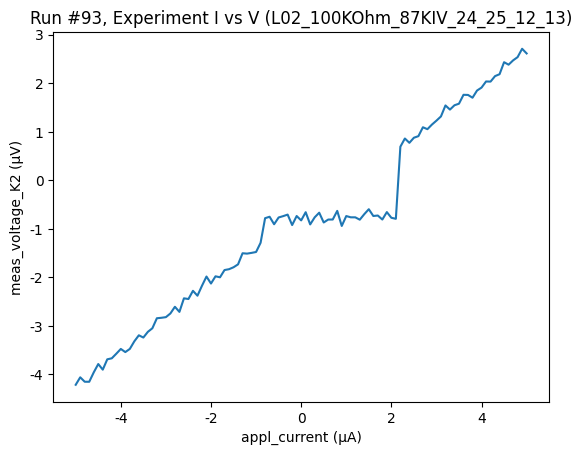

In [8]:
dataset = qc.load_by_id(93)
plot= plot_dataset(dataset)

In [49]:
plot_IV_and_dVdI(167)

Ic = 21.5 µA
Ir = -19.5 µA
R_fit = 7.468455232938625 Ω
IcRn = 160.57178750818045 µV
R_fit0 = 7.212185220779223 Ω
R_fit1 = 7.7247252450980275 Ω
R_fit_SC = 0.327013656442186 Ω
Rn = 7.141441576496439 Ω



/opt/anaconda3/envs/py3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log10



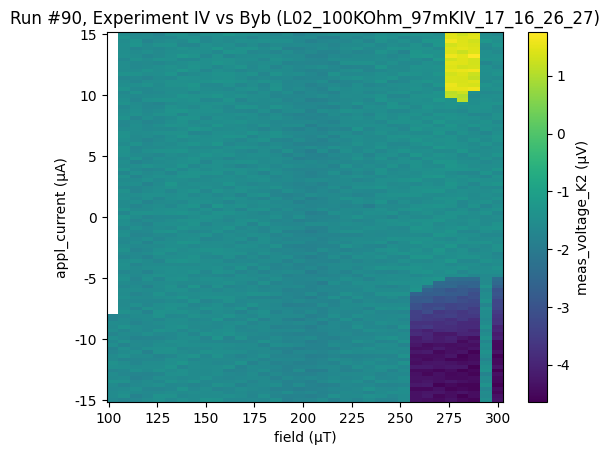

In [59]:
IV_Mag_plot(90)

In [10]:
IV_diff(93)

In [9]:
IV(run_id=93)

In [ ]:
IV(12)

In [ ]:
IV(12)
IV_diff(12)

# IV_Mag_plot

In [ ]:
IV_Mag_plot(6509, log_lower_limit=20)

# IV_RF_f_linecut

In [ ]:
IV_RF_f_linecut(6521,[5.53,55,5.5534,5.56,5.58])

In [ ]:
dataset = qc.load_by_id(6511)
run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(
        dataset)
df = dataset.to_pandas_dataframe().reset_index()
# Plot the dataset
plot_dataset(dataset)
para_list = dataset.parameters.split(",")

fig1 = go.Figure(data=go.Heatmap(
    x=df[para_list[1]],
    y=df[para_list[2]],
    z=df[para_list[0]],
    colorscale='RdBu',
    colorbar=dict(
        title=para_list[0], titleside='right')),
    layout=dict(
        title=f"#{run_id} {exp_name} {sample_name}",
        xaxis_title=para_list[1],
        yaxis_title=para_list[2],
        height=800, width=800
        ))
fig1.show()

In [ ]:
import plotly.graph_objects as go

fig1 = go.Figure(data=go.Scatter(
    x=df[para_list[1]],
    y=df[para_list[2]],
    mode='markers',  # Set mode to 'markers' for individual points
    marker=dict(
        size=10,  # Adjust marker size as desired
        color=df[para_list[0]],  # Use the same data for color
        colorscale='RdBu',  # Maintain the same color scale
        colorbar=dict(
            title=para_list[0],
            titleside='right'
        )
    )
))

# Keep the layout the same for title, axis labels, and dimensions
fig1.update_layout(
    title=f"#{run_id} {exp_name} {sample_name}",
    xaxis_title=para_list[1],
    yaxis_title=para_list[2],
    height=800,
    width=800
)

fig1.show()


In [ ]:
import numpy as np
import plotly.graph_objs as go

# Generate some sample data
t = np.linspace(0, 1, 1000)  # Time points from 0 to 1 with 1000 samples
frequency = 5  # Frequency of the signal
amplitude = 2  # Amplitude of the signal
signal = amplitude * np.sin(2 * np.pi * frequency * t)  # Generate a sine wave signal

# Compute the FFT
fft_result = np.fft.fft(signal)
frequencies = np.fft.fftfreq(len(signal), t[1] - t[0])  # Compute the frequencies corresponding to FFT result

# Plot the original signal
original_signal_trace = go.Scatter(x=t, y=signal, mode='lines', name='Original Signal')

# Plot the FFT of the signal
fft_trace = go.Scatter(x=frequencies, y=np.abs(fft_result), mode='lines', name='FFT')

# Layout settings
layout = go.Layout(
    title='FFT using Plotly',
    xaxis=dict(title='Frequency'),
    yaxis=dict(title='Amplitude'),
    showlegend=True
)

# Create the figure and plot
fig = go.Figure(data=[original_signal_trace, fft_trace], layout=layout)
fig.show()


In [ ]:
import numpy as np
import plotly.graph_objs as go

# Assuming you have already calculated the FFT and frequencies

# Create a Plotly trace for FFT spectrum
fft_trace = go.Scatter(x=frequencies, y=fft_magnitude, mode='lines', name='FFT Spectrum')

# Layout settings
layout = go.Layout(
    title='FFT Spectrum using Plotly',
    xaxis=dict(title='Frequency'),
    yaxis=dict(title='Magnitude'),
    showlegend=True
)

# Create the figure and plot
fig = go.Figure(data=[fft_trace], layout=layout)
fig.show()


In [ ]:
import plotly.graph_objects as go

# Assuming df is your pandas DataFrame
x = df[para_list[0]].values
y = df[para_list[1]].values
z = df[para_list[2]].values

# Choose the time-series component you want to analyze
# For example, let's take the 'z' component
signal = y

# Calculate the FFT
fft_signal = fft(signal)

# Get the frequencies corresponding to the FFT coefficients
n = len(signal)
sample_rate = 10 # Assuming a sample rate of 1 (you may need to adjust this)
frequencies = fftfreq(n, d=0.00001/sample_rate)

# Calculate magnitude of FFT coefficients
fft_magnitude = np.abs(fft_signal)

# Create a plotly trace for the FFT spectrum
trace = go.Scatter(
    x=frequencies,
    y=fft_magnitude,
    mode='lines',
    name='FFT Magnitude'
)

# Create the layout for the plot
layout = go.Layout(
    title='FFT Spectrum',
    xaxis=dict(
        title='Frequency'
    ),
    yaxis=dict(
        title='Magnitude'
    )
)

# Create the figure with trace and layout
fig = go.Figure(data=[trace], layout=layout)

# Display the plot
fig.show()


In [ ]:
import plotly.graph_objects as go

# Assuming df is your pandas DataFrame
x = df[para_list[0]].values
y = df[para_list[1]].values
z = df[para_list[2]].values
d = df['differential_voltage'] = (
        df[para_list[2]].shift(-1) -
        df[para_list[2]].shift(1)) / (2 * (df[para_list[1]].shift(-1) - df[para_list[1]]))

# Choose the time-series component you want to analyze
# For example, let's take the 'z' component
signal = y

# Calculate the FFT
fft_signal = fft(signal)

# Get the frequencies corresponding to the FFT coefficients
n = len(signal)
sample_rate = 10 # Assuming a sample rate of 1 (you may need to adjust this)
frequencies = fftfreq(n, d=0.00001/sample_rate)

# Calculate magnitude of FFT coefficients
fft_magnitude = np.abs(fft_signal)

# Create traces for original signal and FFT spectrum
trace1 = go.Scatter(
    x=d,  # Use the original time values for x-axis
    y=abs(d),
    mode='lines',
    name='Original Signal'
)

trace2 = go.Scatter(
    x=frequencies,
    y=fft_magnitude,
    mode='lines',
    name='FFT Magnitude'
)

# Create the layout for the plot
layout = go.Layout(
    title='Original Signal and FFT Spectrum',
    xaxis=dict(
        title='Time'  # Adjust title based on your x-axis data
    ),
    yaxis=dict(
        title='Amplitude'
    )
)

# Create the figure with traces and layout
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Display the plot
fig.show()


# IV_RF_PD_linecut

In [ ]:
IV_RF_PD_linecut(6521,[8,10,12,14,15.9])

In [ ]:
dataset = qc.load_by_id(6499)
df = dataset.to_pandas_dataframe().reset_index()
para_list = dataset.parameters.split(",")
df['differential_voltage'] = (
        df[para_list[2]].shift(-1) -
        df[para_list[2]].shift(1)) / (2 * (df[para_list[1]].shift(-1) - df[para_list[1]]))
# Assuming df is your pandas DataFrame
x = df[para_list[0]].values
y = df[para_list[1]].values
z = df[para_list[2]].values

# Choose the time-series component you want to analyze
# For example, let's take the 'z' component
signal = y

# Calculate the FFT
fft_signal = fft(signal)

# Get the frequencies corresponding to the FFT coefficients
n = len(signal)
sample_rate = 10 # Assuming a sample rate of 1 (you may need to adjust this)
frequencies = fftfreq(n, d=0.00001/sample_rate)

# You can now analyze the FFT coefficients and corresponding frequencies
# For example, to get the magnitude of the FFT coefficients
fft_magnitude = np.abs(fft_signal)



# You can also plot the FFT spectrum
import matplotlib.pyplot as plt

plt.plot(frequencies, fft_magnitude)
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.show()